In [1]:
import pandas as pd

In [31]:
#Importing the data
df = pd.read_csv("Seven_Sins_Restobar.tsv", delimiter = '\t', quoting = 3, encoding = 'unicode_escape')
df.head()


Review  Liked
0  "I also had to taste my Mom's multi-grain pump...      1
1          "I'd rather eat airline food, seriously."      0
2      Cant say enough good things about this place.      1
3                       The ambiance was incredible.      1
4          The waitress and manager are so friendly.      1

The first step is review the data, to see if there are null values and the behavior of the variables.

In [16]:
df.dtypes

Review    object
Liked      int64
dtype: object

In [17]:
df.describe()

Liked
count  500.000000
mean     0.500000
std      0.500501
min      0.000000
25%      0.000000
50%      0.500000
75%      1.000000
max      1.000000

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
df.isnull().sum()

Review    0
Liked     0
dtype: int64

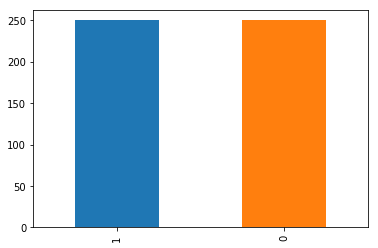

In [21]:
Liked = df.Liked.value_counts()
Liked.plot(kind="bar")

There are two variables:
  * Review: Categorical, a text which contains a review of the restaurant
  * Liked: Categorical, can take two values -> 1 (Liked) and 0 (disliked)

We can see that there is not missing values for any variable.
Now we can start with the study.

In [25]:
import nltk
import re

Main objetive of the study: To analize the relationship between the text reviews and the likes/dislikes of the restaurant, with this information i can determine if future comments and reviews are a signal of good or bad reception.

My main focus will be to determine correctly the number of persons that really liked the local.

I will start cleaning the data by removing all but letters and Capitals.

In [33]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#Cleaning the data

corpus = [] 

for i in range(0, 500):
    Review = re.sub('[^a-zA-Z]', ' ', df['Review'][i]) 
    Review = Review.lower() 
    Review = Review.split() 
    ps = PorterStemmer()    #I am using the Stemming Text Normalization technique
    Review = [ps.stem(word) for word in Review if not word in set(stopwords.words('english'))]
    Review = ' '.join(Review) 
    corpus.append(Review) 

In [40]:
type(corpus)

list

After cleaning  the data, I will consider the 1000 more frequent words, creating after the Sparse Matrix that contains the most frequent words (columns) and if they are present in each review (rows). I will also define the response variable(Liked), it will be determiated by the review.

In [41]:
from sklearn.feature_extraction.text import CountVectorizer #Class that allows tokenization

cv = CountVectorizer(max_features = 1000) #Keepong the 1000 more frequent words

#Now i create the Sparse Matrix 
X = cv.fit_transform(corpus).toarray() 

#defining the response variable(Liked)
y = df.iloc[:, 1].values 

In [45]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
!pip install tabulate
from tabulate import tabulate
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

  Running setup.py bdist_wheel for tabulate: started
  Running setup.py bdist_wheel for tabulate: finished with status 'done'
  Stored in directory: C:\Users\Ivo.Carvallo\AppData\Local\pip\Cache\wheels\9c\9b\f4\eb243fdb89676ec00588e8c54bb54360724c06e7fafe95278e
Successfully built tabulate


In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 

We will use three models to train the data:
    * Naive Bayes
    * Logistic Regression
    * Random Forest

In [52]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Fitting Naive Bayes to the Training set, this model make the assumption that there is not a relationships between the likes and the dislikes

from sklearn.naive_bayes import GaussianNB
classifier_nb = GaussianNB()
classifier_nb.fit(X_train, y_train)

# fit a Logistic Regression Model
classifier_lr = LogisticRegression(solver='lbfgs')
classifier_lr.fit(X_train, y_train)

#Fit a Random forest Model
rf = RandomForestClassifier(criterion='entropy', oob_score=True, random_state=1)
rf.fit(X_train, y_train)

# Predicting the Test set results
nb_y_pred = classifier_nb.predict(X_test)
lr_y_pred = classifier_lr.predict(X_test)
rf_y_pred = rf.predict(X_test)

# The next step is the Confusion matrix, obtained with the results of the Model and allowing me to see the predicted and actual values.
from sklearn.metrics import confusion_matrix
nb_cm = confusion_matrix(y_test, nb_y_pred)  #CM for Naive Bayes
print(nb_cm)

lr_cm = confusion_matrix(y_test, lr_y_pred)  #CM for Logistic regression
print(lr_cm)

rf_cm = confusion_matrix(y_test, rf_y_pred)   #CM for Random Forest
print(rf_cm)

[[27 23]
 [ 6 44]]
[[35 15]
 [15 35]]
[[38 12]
 [17 33]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


No Skill: ROC AUC=0.500
Naive Bayes: ROC AUC=0.710
Logistic: ROC AUC=0.768
RandomForest: ROC AUC=0.744


threshold  tpr  fpr
0          1  0.0  0.0
1          0  1.0  1.0

threshold   tpr   fpr
0        2.0  0.00  0.00
1        1.0  0.88  0.46
2        0.0  1.00  1.00

threshold   tpr   fpr
0    1.999911  0.00  0.00
1    0.999911  0.02  0.00
2    0.963908  0.10  0.00
3    0.952055  0.10  0.02
4    0.808690  0.34  0.02
5    0.794672  0.34  0.06
6    0.771599  0.40  0.06
7    0.751255  0.40  0.10
8    0.735760  0.42  0.10
9    0.733391  0.42  0.12
10   0.702609  0.52  0.12
11   0.697616  0.52  0.14
12   0.681008  0.54  0.14
13   0.676496  0.54  0.16
14   0.674784  0.56  0.16
15   0.663734  0.56  0.18
16   0.640720  0.58  0.18
17   0.634032  0.58  0.20
18   0.586230  0.64  0.20
19   0.567556  0.64  0.22
20   0.554834  0.66  0.22
21   0.544225  0.66  0.26
22   0.526270  0.70  0.26
23   0.485879  0.70  0.34
24   0.470072  0.72  0.34
25   0.466426  0.72  0.36
26   0.452494  0.76  0.36
27   0.428239  0.76  0.42
28   0.392767  0.84  0.42
29   0.381911  0.84  0.46
30   0.381492  0.86  0.46
31   0.350426  0.86  0.52
32   0.348744  0.88  0.52
33   0.320811  0.88  0.62
34   0.315424  0.90  0.62
35   0.266787  0.90  0.74
36   0.261844  0.92  0.74
37   0.253786  0.92  0.80
38   0.238886  0.94  0.80
39   0.211520  0.94  0.82
40   0.211244  0.96  0.82
41   0.155739  0.96  0.94
42   0.137476  0.98  0.94
43   0.088363  0.98  1.00
44   0.049517  1.00  1.00

threshold   tpr   fpr
0         2.0  0.00  0.00
1         1.0  0.16  0.04
2         0.9  0.44  0.08
3         0.8  0.54  0.16
4         0.7  0.60  0.16
5         0.6  0.66  0.24
6         0.5  0.70  0.28
7         0.4  0.78  0.34
8         0.3  0.80  0.46
9         0.2  0.82  0.56
10        0.1  0.84  0.70
11        0.0  1.00  1.00

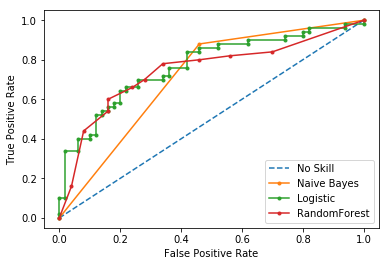

LR Sensitivity: 0.9
LR Specificity: 0.38
NB Sensitivity: 0.88
NB Specificity: 0.54
RF Sensitivity: 0.78
RF Specificity: 0.6599999999999999
LR Sensitivity: 0.76
LR Specificity: 0.5800000000000001
NB Sensitivity: 0.88
NB Specificity: 0.54
RF Sensitivity: 0.7
RF Specificity: 0.72
LR Sensitivity: 0.7
LR Specificity: 0.74
NB Sensitivity: 0.88
NB Specificity: 0.54
RF Sensitivity: 0.66
RF Specificity: 0.76
LR Sensitivity: 0.58
LR Specificity: 0.8
NB Sensitivity: 0.88
NB Specificity: 0.54
RF Sensitivity: 0.6
RF Specificity: 0.84
LR Sensitivity: 0.52
LR Specificity: 0.88
NB Sensitivity: 0.88
NB Specificity: 0.54
RF Sensitivity: 0.54
RF Specificity: 0.84


In [60]:
# predict probabilities
nb_probs = classifier_nb.predict_proba(X_test)
lr_probs = classifier_lr.predict_proba(X_test)
rf_probs = rf.predict_proba(X_test)

# keep probabilities for the positive outcome only
ns_probs = [0 for _ in range(len(y_test))]
nb_probs = nb_probs[:, 1]
lr_probs = lr_probs[:, 1]
rf_probs = rf_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
nb_auc = roc_auc_score(y_test, nb_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
rf_auc = roc_auc_score(y_test, rf_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Naive Bayes: ROC AUC=%.3f' % (nb_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('RandomForest: ROC AUC=%.3f' % (rf_auc))

# calculate roc curves
ns_fpr, ns_tpr, ns_thresholds  = roc_curve(y_test, ns_probs)
nb_fpr, nb_tpr, nb_thresholds  = roc_curve(y_test, nb_probs)
lr_fpr, lr_tpr, lr_thresholds  = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, rf_thresholds  = roc_curve(y_test, rf_probs)

#get roc curve metrics
from IPython.display import display

ns_df = pd.DataFrame(data=[])
ns_df['threshold'] = ns_thresholds
ns_df['tpr'] = ns_tpr
ns_df['fpr'] = ns_fpr
display(ns_df)

nb_df = pd.DataFrame(data=[])
nb_df['threshold'] = nb_thresholds
nb_df['tpr'] = nb_tpr
nb_df['fpr'] = nb_fpr
display(nb_df)

lr_df = pd.DataFrame(data=[])
lr_df['threshold'] = lr_thresholds
lr_df['tpr'] = lr_tpr
lr_df['fpr'] = lr_fpr
display(lr_df)

rf_df = pd.DataFrame(data=[])
rf_df['threshold'] = rf_thresholds
rf_df['tpr'] = rf_tpr
rf_df['fpr'] = rf_fpr
display(rf_df)

# plot the roc curve for the model

fig, ax1 = pyplot.subplots()

ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
ax1.plot(nb_fpr, nb_tpr, marker='.', label='Naive Bayes')
ax1.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
ax1.plot(rf_fpr, rf_tpr, marker='.', label='RandomForest')

# axis labels
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()

# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold_lr(threshold):
    print('LR Sensitivity:', lr_tpr[lr_thresholds > threshold][-1])
    print('LR Specificity:', 1 - lr_fpr[lr_thresholds > threshold][-1])
    
def evaluate_threshold_nb(threshold):
    print('NB Sensitivity:', nb_tpr[nb_thresholds > threshold][-1])
    print('NB Specificity:', 1 - nb_fpr[nb_thresholds > threshold][-1])
    
def evaluate_threshold_rf(threshold):
    print('RF Sensitivity:', rf_tpr[rf_thresholds > threshold][-1])
    print('RF Specificity:', 1 - rf_fpr[rf_thresholds > threshold][-1])

evaluate_threshold_lr(0.3)
evaluate_threshold_nb(0.3)
evaluate_threshold_rf(0.3)

evaluate_threshold_lr(0.4)
evaluate_threshold_nb(0.4)
evaluate_threshold_rf(0.4)

evaluate_threshold_lr(0.5)
evaluate_threshold_nb(0.5)
evaluate_threshold_rf(0.5)

evaluate_threshold_lr(0.6)
evaluate_threshold_nb(0.6)
evaluate_threshold_rf(0.6)

evaluate_threshold_lr(0.7)
evaluate_threshold_nb(0.7)
evaluate_threshold_rf(0.7)

As previously stated, the main focus is determine correctly the number of persons that really liked the local, because of this i am most interested in getting a higher Sensitivity (True positives) than a good result at Specificity (False positives).

I will consider two criteria to select a model:

    1- Predict_proba metric
    2- Threshold evaluation

1) The predict_proba metric gives me a probability value for each model that represents the area under the curve, because of this I would prefer high values. 

- No Skill: 0.500
- Naive Bayes: 0.710
- Logistic: 0.768
- RandomForest: 0.744

We can see in the results that the Logistic and the Random Forest had the better performance, followed by Naive Bayes.

2) Looking at the results of different thresholds (0.3, 0.4, 0.5, 0.6 and 0.7) and the final plot, Naive Bayes gets the better results for Sensitivity, being very superior to the other models.

Considering that Naive Bayes got a great result in 2) and not a bad performance in 1), i would recommend this model to reach the objetive stated at the beginning. 

Observations: For future I would recommend to try the data clean using Lemmatization instead of Stemming to see if i can get better results.